# <p style="text-align: center;">Convolutional Neural Network (CNN) example in Keras <br>for classifying images
</p>

<p style="text-align: center;">
 by Prof. Dr.-Ing. Jürgen Brauer, http://www.juergenbrauer.org
</p>

## Table of Contents

1. Download some images
2. Check whether OpenCV is installed
3. Load one of the images and display it
4. Loading a batch of images
5. Prepare training and test data
6. Defining a CNN and training in Keras
7. Saving weights and model configuration
8. Plotting loss and accuracy curves
9. Restoring a previously saved model
10. Testing the trained model on new images

## 1. Download some images

We need training and test images. So let's download some!

Go to http://www.image-net.org/ and download test images for the following classes:
- birds (2126)
- mice (956)
- cats (1831)
- dogs (1603)
- horses (1402)

The number in the brackets specifies how much images I got from ImageNet for the corresponding class.

## 2. Check whether OpenCV is installed

In [1]:
import cv2
print("Your OpenCV version is: "+ cv2.__version__)

Your OpenCV version is: 3.4.1


## 3. Load one of the images and display it

Type of image is <class 'numpy.ndarray'>
Image has dimensions : (233, 350, 3)


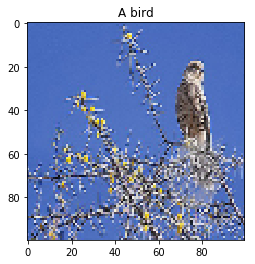

In [2]:
import matplotlib.pyplot as plt

# 1.
# Load image and display information about it
filename = "V:\\01_job\\12_datasets\\01_imagenet_birds\\n01503061_3.JPEG"
#filename = "/home/paperspace/jb_datasets/01_imagenet_birds/n01503061_3.JPEG"
image = cv2.imread(filename)
print("Type of image is", type(image))
print("Image has dimensions :", image.shape)

# 2.
# OpenCV stores images in BGR color order,
# but MatplotLib expects RGB color order
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 3.
# Resize image to desired size
IMG_SIZE = (100,100)
image = cv2.resize(image, IMG_SIZE) 

# 4.
# Show image
plt.imshow(image)
plt.title("A bird")
plt.show()

## 4. Loading a batch of images

Great! Now, that we have seen how to load images, we would like to load all bird images by some helper function and get all these images as a list:

In [3]:
from os import listdir
from os.path import isfile, join
import numpy as np

IMG_SIZE = (100,100)

def load_images(foldername):
    
    filenames = [f for f in listdir(foldername) if isfile(join(foldername, f))]
    nr_images = len(filenames)
    
    images = np.zeros((nr_images, IMG_SIZE[0], IMG_SIZE[1], 3))
        
    for img_nr,filename in enumerate(filenames):
        absolute_filename = foldername + "/" + filename
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMG_SIZE ) 
        image = image * (1.0/255.0)
        
        # set image in 4D array
        images[img_nr] = image
        
    print("I have read", len(filenames),
          "images from folder", foldername)
    return images
    
        
        
categories = ["birds", "mice", "cats", "dogs", "horses"]
root_dir = "V:\\01_job\\12_datasets\\"
#root_dir = "/home/paperspace/jb_datasets/"
folder_per_cat = {"birds"  : root_dir+"01_imagenet_birds",
                  "mice"   : root_dir+"02_imagenet_mice",
                  "cats"   : root_dir+"03_imagenet_cats",
                  "dogs"   : root_dir+"04_imagenet_dogs",
                  "horses" : root_dir+"05_imagenet_horses"}

bird_images   = load_images(folder_per_cat["birds"])
mice_images   = load_images(folder_per_cat["mice"])
cats_images   = load_images(folder_per_cat["cats"])
dogs_images   = load_images(folder_per_cat["dogs"])
horses_images = load_images(folder_per_cat["horses"])

I have read 2126 images from folder V:\01_job\12_datasets\01_imagenet_birds
I have read 956 images from folder V:\01_job\12_datasets\02_imagenet_mice
I have read 1831 images from folder V:\01_job\12_datasets\03_imagenet_cats
I have read 1603 images from folder V:\01_job\12_datasets\04_imagenet_dogs
I have read 1402 images from folder V:\01_job\12_datasets\05_imagenet_horses


## 5. Prepare training and test data

Image training data for a CNN in Keras is expected to be a 4D NumPy array of shape:

    nr_images x img_height x img_width x nr_channels
    
For shuffling the training images, we use the permutation class of NumPy:

In [4]:
test_array = np.arange(10).reshape((5, 2))
permut = np.random.permutation(test_array.shape[0])
print("permut=",permut)
print("test_array before:", test_array)
test_array = np.take(test_array, permut, axis=0)
print("test_array after:", test_array)


permut= [2 3 0 4 1]
test_array before: [[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
test_array after: [[4 5]
 [6 7]
 [0 1]
 [8 9]
 [2 3]]


In [5]:
print("bird_images has shape",bird_images.shape)
print("mice_images has shape",mice_images.shape)

labels_bird_images = np.zeros( (bird_images.shape[0],1) )
labels_bird_images[:,0] = 0

labels_mice_images = np.zeros( (mice_images.shape[0],1) )
labels_mice_images[:,0] = 1

labels_cats_images = np.zeros( (cats_images.shape[0],1) )
labels_cats_images[:,0] = 2

labels_dogs_images = np.zeros( (dogs_images.shape[0],1) )
labels_dogs_images[:,0] = 3

labels_horses_images = np.zeros( (horses_images.shape[0],1) )
labels_horses_images[:,0] = 4

X = np.vstack((bird_images,
               mice_images,
               cats_images,
               dogs_images,
               horses_images))
print("X has shape", X.shape)

Y = np.vstack( (labels_bird_images,
                labels_mice_images,
                labels_cats_images,
                labels_dogs_images,
                labels_horses_images))
print("Y has shape", Y.shape)

# Shuffle data
some_permutation = np.random.permutation(X.shape[0])
X = np.take(X,some_permutation,axis=0)
Y = np.take(Y,some_permutation,axis=0)

# Split data into training and testing data
TEST_DATA_RATIO = 0.1
nr_train_images = int((1-TEST_DATA_RATIO)*X.shape[0])
print("The", X.shape[0], "many images will be split "
      "into train and test images.")
X_train = X[0:nr_train_images]
Y_train = Y[0:nr_train_images]
X_test  = X[nr_train_images:]
Y_test  = Y[nr_train_images:]
print("Shape of X_train is", X_train.shape)
print("Shape of X_test is", X_test.shape)


bird_images has shape (2126, 100, 100, 3)
mice_images has shape (956, 100, 100, 3)
X has shape (7918, 100, 100, 3)
Y has shape (7918, 1)
The 7918 many images will be split into train and test images.
Shape of X_train is (7126, 100, 100, 3)
Shape of X_test is (792, 100, 100, 3)


Now we will prepare a one-hot encoding for the training data labels, which are between 0 and 4.

In [6]:
from keras.utils import to_categorical

print(Y_train)
Y_train_one_hot_encoded = to_categorical(Y_train)
print(Y_train_one_hot_encoded)
Y_test_one_hot_encoded = to_categorical(Y_test)

Using TensorFlow backend.


[[ 0.]
 [ 4.]
 [ 2.]
 ..., 
 [ 3.]
 [ 2.]
 [ 0.]]
[[ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.]
 ..., 
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.]]


## 6. Defining a CNN and training in Keras

Now let's define a CNN model and feed it with the training images.



In [7]:
import keras
from keras import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization

NUM_CLASSES = 5

# 1.
# Define the input shape of the CNN:
# img_height x img_width x nr_channels
the_input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)


# 2.
# Define the CNN model
# See https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py
def a_simple_cnn():

    # Initialize model
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=the_input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model
    
model = a_simple_cnn()


# 3.
# Compile model and show model summary


#model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


# 4.
# Train model
print("Training input data has shape", X_train.shape)
print("Training output data has shape", Y_train_one_hot_encoded.shape)
        
history = model.fit(X_train, Y_train_one_hot_encoded,
                    validation_split=0.25, batch_size=64, epochs=5)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 154885    
Total params: 208,581
Trainable params: 208,581
Non-trainable params: 0
_________________________________________________________________
Trai

KeyboardInterrupt: 

Why are there 2432 parameters for the first CONV layer?
Each of the 32 filters gets inputs from 5x5x3 input values = 32*75 = 2400. And do not forget that each filter has a single bias value --> 2432 weights.

Why are there 51264 parameters for the second CONV layer?
Each of the 64 filters gets input from 5x5x32 input values = 64*5*5*32 = 51200. And do not forget that each filter has a single bias value --> 51264 weights.

Why are there 14.137.700 parameters in the first dense layer?
Each of the 100 neurons in this layers gets input from the flatten layer, which contains 47*47*64=141.376 values --> 141.376*100 = 14.137.600 weights. And do not forget that each neuron has a single bias value --> 14.137.700 weights!


## 7. Saving weights and model configuration

Training a CNN can take a long time! So it is a good idea to save the model and the weights and reload both if it is time for inference.

In [12]:
# Save the weights
model.save_weights('model_weights.h5')

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

This will generate two files:

    - model_architecture.json (ca. 3 KB)
    - model_weights.h5 (ca. 55 MB!)


## 8. Plotting loss and accuracy curves

The following keys are stored in the training history:
 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
loss history has len 5
[0.4921688480291538, 0.48833932169897115, 0.48520120175298814, 0.48161515843368574, 0.47891687847183134]


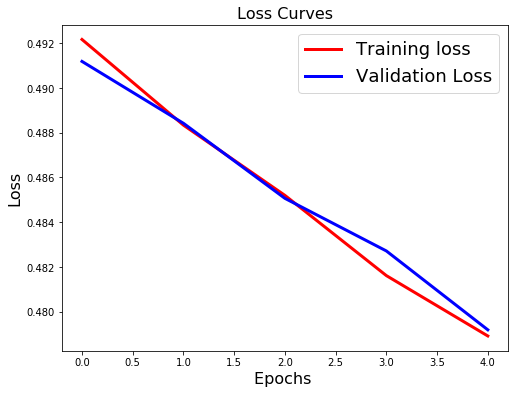

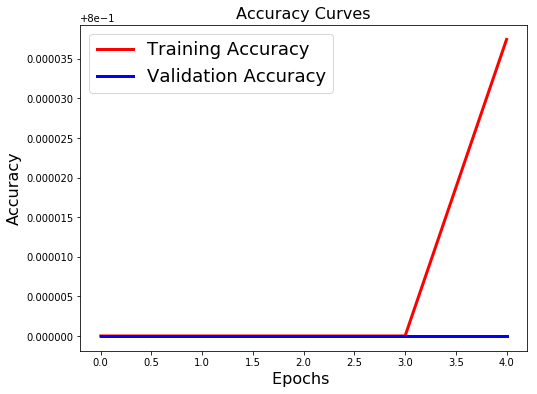

In [13]:
print("The following keys are stored in the training history:\n",
      history.history.keys())
print("loss history has len", len(history.history['loss']))
print(history.history['loss'])

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

plt.show()

## 9. Restoring a previously saved model

In [14]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('model_weights.h5')

## 10. Testing the trained model on new images

Shape of nr_test_images is (792, 100, 100, 3)
There are 792 test images.


/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  app.launch_new_instance()


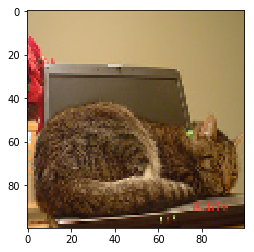

[0. 0. 1. 0. 0.]
Ground truth class: cats
predicted_label= [[0.20292345 0.13405812 0.20307696 0.21460494 0.24533655]]


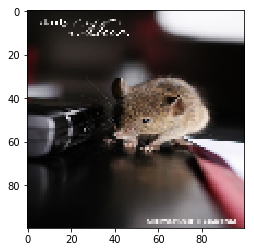

[0. 1. 0. 0. 0.]
Ground truth class: mice
predicted_label= [[0.23461916 0.15841542 0.21974848 0.2219844  0.16523251]]


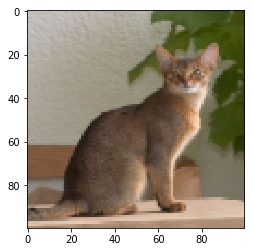

[0. 0. 1. 0. 0.]
Ground truth class: cats
predicted_label= [[0.22274199 0.14900519 0.21916288 0.21705706 0.19203281]]


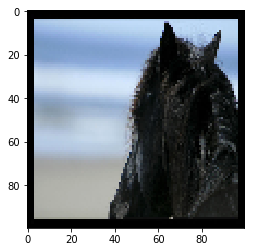

[0. 0. 0. 0. 1.]
Ground truth class: horses
predicted_label= [[0.25024432 0.10287299 0.2298054  0.19250216 0.22457512]]


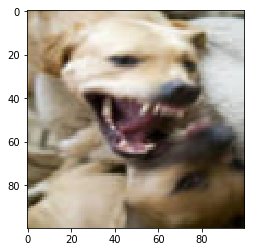

[0. 0. 0. 1. 0.]
Ground truth class: dogs
predicted_label= [[0.22691031 0.10847542 0.23594135 0.2087967  0.21987617]]


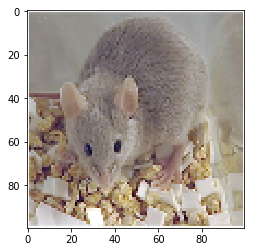

[0. 1. 0. 0. 0.]
Ground truth class: mice
predicted_label= [[0.22767468 0.17075533 0.2401861  0.2230179  0.13836603]]


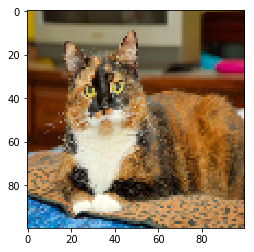

[0. 0. 1. 0. 0.]
Ground truth class: cats
predicted_label= [[0.23527546 0.15083347 0.28731665 0.19232325 0.13425119]]


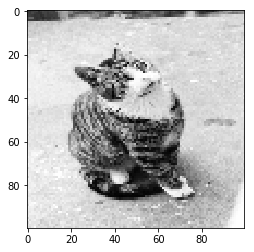

[0. 0. 1. 0. 0.]
Ground truth class: cats
predicted_label= [[0.30370778 0.10395834 0.19334498 0.23781206 0.16117688]]


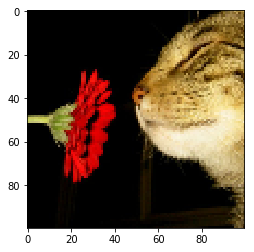

[0. 0. 1. 0. 0.]
Ground truth class: cats
predicted_label= [[0.28388685 0.142145   0.18471901 0.2322535  0.15699568]]


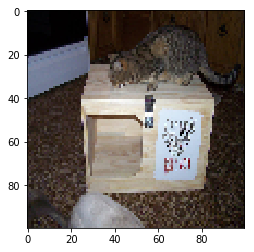

[0. 0. 1. 0. 0.]
Ground truth class: cats
predicted_label= [[0.33198056 0.12366752 0.27048674 0.1889664  0.08489877]]


In [15]:
import scipy.misc

print("Shape of nr_test_images is", X_test.shape)

nr_test_images = X_test.shape[0]
print("There are", nr_test_images, "test images.")

NR_IMAGES_TO_TEST = 10
for test_img_nr in range(0, min(NR_IMAGES_TO_TEST,nr_test_images)):
    
    # get the image from the 4D NumPy array
    img_data = X_test[test_img_nr]
    
    # convert NumPy data back to an OpenCV image
    # in order to display it correctly
    testimg = scipy.misc.toimage(img_data)
    
    # show the image
    plt.imshow(testimg)
    plt.show()
    
    # get ground truth label for this image
    print(Y_test_one_hot_encoded[test_img_nr])
    gt_label = np.argmax(Y_test_one_hot_encoded[test_img_nr])
    print("Ground truth class:", categories[gt_label])
    
    # let our trained model predict the class!
    img_data_as_4d_array = img_data.reshape((-1,
                                             img_data.shape[0],
                                             img_data.shape[1],
                                             img_data.shape[2])
                                           )
    predicted_label = model.predict(img_data_as_4d_array)
    print("predicted_label=", predicted_label)
    
    
    
    
